In [2]:
import numpy as np
import pandas as pd
import GPy
import pickle
import pathlib
import copy

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.model_selection import train_test_split

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [3]:
import itertools
datafile = 'data/jass/rnd_01.csv'
col_names = [a+str(b) for (a,b) in itertools.product([farbe for farbe in 'HKSE'], [bild for bild in range(9)])]+["Geschoben", "Player", "Aktion"]
data = pd.read_csv(datafile, header=None, names=col_names)
data

,H0,H1,H2,H3,H4,H5,H6,H7,H8,K0,...,E2,E3,E4,E5,E6,E7,E8,Geschoben,Player,Aktion
0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,1631,2
1,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,64310,6
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,16721,1
3,1,0,0,0,1,0,0,0,1,1,...,0,0,1,0,1,0,0,1,0,4
4,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,72620,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161689,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,55942,3
161690,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,6
161691,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,0,3
161692,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,60659,6


## Binary Classification on targets 0 and 1

In [4]:
# select subset of data
target_classes = [0,1]
zeroone = data[data['Aktion'].isin(target_classes)]
zeroone = zeroone.drop(columns='Player')
X = zeroone.loc[:,'H0':'Geschoben'].values
y = zeroone.loc[:,'Aktion']

# make sure targets are binary (required by GPC implementation of sklearn)
y = y.isin(target_classes[0:1]) # first class = 1, second = 0
y = y.values

In [5]:
metrics_template = {
    'acc' : [],
    'acc_val' : [],
    'variance' : [],
    'length-scale' : [],
    'log-marginal-likelihood' : []
}

def addToMetrics(m, acc, acc_val, variance, length_scale, log_marginal_likelihood):
    m['acc'].append(acc)
    m['acc_val'].append(acc_val)
    m['variance'].append(variance)
    m['length-scale'].append(length_scale)
    m['log-marginal-likelihood'].append(log_marginal_likelihood)
    
def save_metrics(m, name, path='./metrics/06_Jass_GP_binary/', overwrite=False):
    _file = pathlib.Path(path+name)
    if _file.exists():
        if overwrite:
                _file.unlink()
        else:
            print('%s file already exists' % (str(path+name)))
            return
    with open(path+name, 'xb') as f:
        pickle.dump(m, f)
    
def load_metrics(name, path='./metrics/06_Jass_GP_binary/'):
    return pickle.load(open(path+name, 'rb'))

def print_metrics(m):
    for k, v in m.items():
        print(k+': %.3f +/- %.3f' % (np.mean(v), np.std(v)*1.28))

### With sklearn (uses Laplace approx)

In [5]:
%%time
metrics_01 = copy.deepcopy(metrics_template)
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=500, test_size=10000, random_state=i)
    kernel = 1.0*RBF()
    clf = GaussianProcessClassifier(kernel, n_restarts_optimizer=0, random_state=23)
    _ = clf.fit(X_train, y_train)
    acc = clf.score(X_train, y_train)
    acc_val = clf.score(X_test, y_test)
    addToMetrics(metrics_01, acc, acc_val, clf.kernel_.k1.get_params()['constant_value'], clf.kernel_.k2.get_params()['length_scale'], clf.log_marginal_likelihood())
print_metrics(metrics_01)
save_metrics(metrics_01, '01')

acc: 0.992 +/- 0.005
acc_val: 0.950 +/- 0.005
variance: 5952.801 +/- 4522.270
length-scale: 19.494 +/- 5.997
log-marginal-likelihood: -106.956 +/- 11.129
CPU times: user 49.4 s, sys: 50.6 s, total: 1min 39s
Wall time: 17.3 s


### With GPy (uses EP approx)

In [6]:
%%time
metrics_02 = copy.deepcopy(metrics_template)
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=500, test_size=10000, random_state=i)
    m = GPy.models.GPClassification(X_train,y_train.reshape(-1,1))
    for i in range(5):
        m.optimize('bfgs', max_iters=100)
    acc = np.equal(m.predict(X_train)[0].reshape(-1) > 0.5, y_train).mean()
    acc_val = np.equal(m.predict(X_test)[0].reshape(-1) > 0.5, y_test).mean()
    addToMetrics(metrics_02, acc, acc_val, m.kern.variance.values[0], m.kern.lengthscale.values[0], m.log_likelihood())
print_metrics(metrics_02)
save_metrics(metrics_02, '02')

4
4


 /usr/local/lib/python3.6/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


4
4
4
acc: 0.986 +/- 0.003
acc_val: 0.950 +/- 0.006
variance: 1525.256 +/- 1313.029
length-scale: 19.813 +/- 7.667
log-marginal-likelihood: -105.694 +/- 10.774
CPU times: user 25min 14s, sys: 22min 46s, total: 48min 1s
Wall time: 8min 2s


### Increasing training set size

In [7]:
%%time
metrics_03 = copy.deepcopy(metrics_template)
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=1000, test_size=10000, random_state=i)
    m = GPy.models.GPClassification(X_train,y_train.reshape(-1,1))
    for j in range(5):
        m.optimize('bfgs', max_iters=100)
    acc = np.equal(m.predict(X_train)[0].reshape(-1) > 0.5, y_train).mean()
    acc_val = np.equal(m.predict(X_test)[0].reshape(-1) > 0.5, y_test).mean()
    addToMetrics(metrics_03, acc, acc_val, m.kern.variance.values[0], m.kern.lengthscale.values[0], m.log_likelihood())
    print(i)
print_metrics(metrics_03)
save_metrics(metrics_03, '03')

0
1
2
3
4
acc: 0.976 +/- 0.006
acc_val: 0.956 +/- 0.002
variance: 1897.013 +/- 1753.524
length-scale: 23.045 +/- 10.931
log-marginal-likelihood: -167.744 +/- 14.405
CPU times: user 2h 53min 41s, sys: 2h 26min 38s, total: 5h 20min 20s
Wall time: 53min 38s


## Sparse Gaussian Process

In [8]:
%%time
metrics_04 = copy.deepcopy(metrics_template)
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=1000, test_size=10000, random_state=i)
    m = GPy.models.SparseGPClassification(X_train,y_train.reshape(-1,1), num_inducing=150)
    for j in range(6):
        m.optimize('bfgs', max_iters=100)
    acc = np.equal(m.predict(X_train)[0].reshape(-1) > 0.5, y_train).mean()
    acc_val = np.equal(m.predict(X_test)[0].reshape(-1) > 0.5, y_test).mean()
    addToMetrics(metrics_04, acc, acc_val, m.kern.variance.values[0], m.kern.lengthscale.values[0], m.log_likelihood())
    print(i)
print_metrics(metrics_04)
save_metrics(metrics_04, '04')

0
1
2
3
4
acc: 0.974 +/- 0.006
acc_val: 0.956 +/- 0.002
variance: 999.951 +/- 277.412
length-scale: 22.979 +/- 3.109
log-marginal-likelihood: -169.877 +/- 14.773
CPU times: user 43min 24s, sys: 42min 54s, total: 1h 26min 18s
Wall time: 14min 28s


The log-marginal-likelihood of the full and the sparse model is equal (~169). This implies that a sparse model with 150 inducing variables explains the data as well as the full model with 1000 training points!

## Sparse Gaussian Process (on 10'0000)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=10000, test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))

Train: 10000, Test: 10000


In [20]:
%%time
m = GPy.models.SparseGPClassification(X_train,y_train.reshape(-1,1), num_inducing=150)

CPU times: user 22min 36s, sys: 4min 24s, total: 27min
Wall time: 14min 9s


In [21]:
%%time
for i in range(4):
    m.optimize('bfgs', max_iters=100)
    print(m)


Name : SparseGPClassification
Objective : 2843.657954695911
Number of Parameters : 5552
Number of Optimization Parameters : 5552
Updates : True
Parameters:
  SparseGPClassification.  |              value  |  constraints  |  priors
  inducing_inputs          |          (150, 37)  |               |        
  rbf.variance             |  401.8762119633459  |      +ve      |        
  rbf.lengthscale          |  56.47594833397397  |      +ve      |        

Name : SparseGPClassification
Objective : 1059.4795180017463
Number of Parameters : 5552
Number of Optimization Parameters : 5552
Updates : True
Parameters:
  SparseGPClassification.  |               value  |  constraints  |  priors
  inducing_inputs          |           (150, 37)  |               |        
  rbf.variance             |   403.9114604336496  |      +ve      |        
  rbf.lengthscale          |  21.317380886748158  |      +ve      |        

Name : SparseGPClassification
Objective : 1042.5086320014816
Number of Parameter

In [29]:
pred_prob_means = m.predict(X_test)[0].reshape(-1)
pred = pred_prob_means > 0.5
score = np.equal(pred, y_test).mean()
print('Accuracy: %.3f' % score)
print('Kernel Hyperparams:\n  variance    %10.1f\n  length_scale%10.1f\nLog Marginal Likelihood: %.1f' % (m.kern.variance, m.kern.lengthscale, m.log_likelihood()))

Accuracy: 0.964
Kernel Hyperparams:
  variance         404.1
  length_scale      18.4
Log Marginal Likelihood: -1041.5


## Load and plot results

In [114]:
x_ticks = [0,1,2,3]
filenames = ['0'+str(i+1) for i in range(4)]
all_mets = [load_metrics(name) for name in filenames]
test_acc_mean = [np.mean(h['acc_val'],axis=0) for h in all_mets]
test_acc_std = [np.std(h['acc_val'],axis=0)*1.282 for h in all_mets]
train_acc_mean = [np.mean(h['acc'],axis=0) for h in all_mets]
train_acc_std = [np.std(h['acc'],axis=0)*1.282 for h in all_mets]

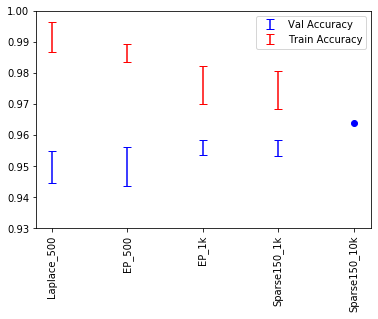

In [115]:
import matplotlib.pyplot as plt
plt.errorbar(x_ticks,test_acc_mean,yerr=test_acc_std, markersize=0, capsize=4, ecolor='b', fmt='b.', label='Val Accuracy')
plt.errorbar(x_ticks,train_acc_mean,yerr=train_acc_std, markersize=0, capsize=4, ecolor='r', fmt='b.', label='Train Accuracy')
plt.scatter(4, 0.964, c='b')
plt.xticks(x_ticks+[4], labels=['Laplace_500', 'EP_500', 'EP_1k', 'Sparse150_1k', 'Sparse150_10k'], rotation=90);
plt.ylim(0.93, 1)
plt.legend();

In [125]:
x_ticks = [0,1,2,3]
filenames = ['0'+str(i+1) for i in range(4)]
all_mets = [load_metrics(name) for name in filenames]
var_mean = [np.mean(np.sqrt(h['variance']),axis=0) for h in all_mets]
var_std = [np.std(np.sqrt(h['variance']),axis=0)*1.282 for h in all_mets]
lengthscale_mean = [np.mean(h['length-scale'],axis=0) for h in all_mets]
lengthscale_std = [np.std(h['length-scale'],axis=0)*1.282 for h in all_mets]
mar_mean = [np.mean(np.exp(h['log-marginal-likelihood']),axis=0) for h in all_mets]
mar_std = [np.std(np.exp(h['log-marginal-likelihood']),axis=0)*1.282 for h in all_mets]

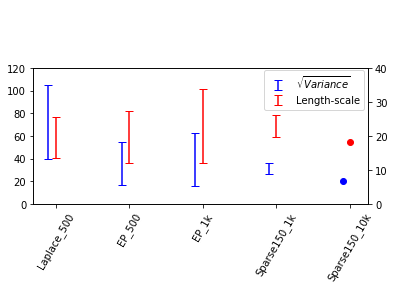

In [128]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(6,2.5))
ax.errorbar(np.array(x_ticks)-0.1,var_mean,yerr=var_std, markersize=0, capsize=4, ecolor='b', fmt='b.', label='$\sqrt{Variance}$')
ax.scatter(3.9, np.sqrt(401), c='b')
ax.set_xticks(x_ticks+[4])
ax.set_xticklabels(['Laplace_500', 'EP_500', 'EP_1k', 'Sparse150_1k', 'Sparse150_10k'],rotation=60);
ax.set_ylim(0,120)

ax2 = ax.twinx()
ax2.errorbar(np.array(x_ticks),lengthscale_mean,yerr=lengthscale_std, markersize=0, capsize=4, ecolor='r', fmt='b.', label='Length-scale')
ax2.scatter(4, 18.4, c='r')
ax2.set_xticks(x_ticks+[4])
ax2.set_xticklabels(['Laplace_500', 'EP_500', 'EP_1k', 'Sparse150_1k', 'Sparse150_10k'],rotation=60);
ax2.set_ylim(0,40)

fig.legend(bbox_to_anchor=(.855,1.25));
